In [1]:
import sys
sys.path.append("../Tracking_SSD_ReID/")
from data_management.VOC2012ManagerObjDetection import VOC2012ManagerObjDetection
manager = VOC2012ManagerObjDetection("../data/VOCdevkit/VOC2012/")
imgs, boxes_gt, classes_gt = manager.getRawData(manager.batches[2][15:20])

import tensorflow as tf
from models.SSD300 import SSD300
n_classes = 21
SSD300_model = SSD300(n_classes)
confs, locs = SSD300_model(imgs)

## Load SSD weights trained on VOC2012

In [2]:
SSD300_model.load_weights("../data/weights_alldata/ssd_weights_epoch_0380.h5")
SSD_backbone = SSD300_model.getVGG16()

## Import VGG16: the feature extractor of the segmentation model

In [3]:
from models.VGG16 import VGG16
input_shape=(300, 300, 3)
VGG16 = VGG16(input_shape=input_shape)
VGG16_tilStage5 = VGG16.getUntilStage5()
VGG16_tilStage5.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1_1 (Conv2D)             (None, 300, 300, 64)      1792      
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 300, 300, 64)      36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 150, 150, 64)      0         
_________________________________________________________________
Conv2_1 (Conv2D)             (None, 150, 150, 128)     73856     
_________________________________________________________________
Conv2_2 (Conv2D)             (None, 150, 150, 128)     147584    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 75, 75, 128)       0         
_________________________________________________________________
Conv3_1 (Conv2D)             (None, 75, 75, 256)      

## Load weights from the SSD model

In [29]:
ssd_seq_idx = 0
ssd_layer_idx = 0
for i in range(len(VGG16_tilStage5.layers)):
    ssd_layer_idx = i
    if i >= 13:
        ssd_seq_idx = 1
        ssd_layer_idx -= 13
    VGG16_tilStage5.get_layer(index=i).set_weights(
        SSD_backbone.get_layer(index=ssd_seq_idx).get_layer(index=ssd_layer_idx).get_weights())
    VGG16_tilStage5.get_layer(index=i).trainable = True

## Add FCN8 decoder

In [50]:
inputs = tf.keras.layers.Input(shape=input_shape)
x = VGG16_tilStage5.get_layer(index=0)(inputs)
for i in range(1, 10):
    x = VGG16_tilStage5.get_layer(index=i)(x)
out_stage_3 = x

for i in range(10, 14):
    x = VGG16_tilStage5.get_layer(index=i)(x)
out_stage_4 = x

for i in range(14, len(VGG16_tilStage5.layers)):
    x = VGG16_tilStage5.get_layer(index=i)(x)

x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)

x = tf.keras.layers.Conv2D(4096, (7, 7), activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(4096, (1, 1), activation='relu', padding='same')(x)

x = tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(4, 4), strides=(2, 2), use_bias=False)(x)
x = tf.keras.layers.Cropping2D(cropping=((2, 1), (1, 2)))(x)

out_stage_4_resized = tf.keras.layers.Conv2D(n_classes, (1, 1), activation='relu', padding='same')(out_stage_4)

x = tf.keras.layers.Add()([x, out_stage_4_resized])

x = (tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(4, 4),  strides=(2, 2), use_bias=False))(x)
x = tf.keras.layers.Cropping2D(cropping=(1, 1))(x)

out_stage_3_resized = tf.keras.layers.Conv2D(n_classes, (1, 1), activation='relu', padding='same')(out_stage_3)

x = tf.keras.layers.Add()([x, out_stage_3_resized])

x = tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(8, 8),  strides=(8, 8), use_bias=False)(x)
x = tf.keras.layers.Cropping2D(cropping=(2, 2))(x)

outputs = tf.keras.layers.Activation('softmax')(x)

In [51]:
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
Conv1_1 (Conv2D)                (None, 300, 300, 64) 1792        input_31[0][0]                   
__________________________________________________________________________________________________
Conv1_2 (Conv2D)                (None, 300, 300, 64) 36928       Conv1_1[30][0]                   
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 150, 150, 64) 0           Conv1_2[30][0]                   
______________________________________________________________________________________

## Prepare VOC2012 segmentation data

In [133]:
import cv2
from PIL import Image
from matplotlib import pyplot as plt
# according to http://host.robots.ox.ac.uk/pascal/VOC/voc2012/segexamples/index.html
labels_to_name = {0:"background", 255:"unlabelled", 1:"aeroplane", 2:"bicycle", 3:"bird", 4:"boat", 5:"bottle",
                  6:"bus", 7:"car" , 8:"cat", 9:"chair", 10:"cow", 11:"diningtable", 12:"dog", 13:"horse",
                  14:"motorbike", 15:"person", 16:"pottedplant", 17:"sheep", 18:"sofa", 19:"train", 20:"tv-monitor"}
width, height, channels = input_shape

In [134]:
VOC2012_path = "../data/VOCdevkit/"
images_path = VOC2012_path + "VOC2012/JPEGImages/"
segmentation_path = VOC2012_path + "VOC2012/SegmentationClass/"

### Visualize VOC2012 segmentation data

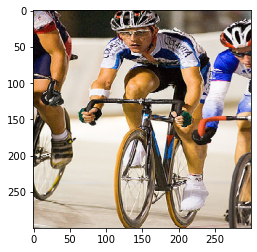

In [135]:
image = Image.open(images_path + "2007_000129.jpg")
image = np.array(image)
image = cv2.resize(image, (width, height,), interpolation=cv2.INTER_LINEAR)
plt.imshow(image)

In [136]:
def get_uniques(t):
    t1d = tf.reshape(t, shape=(-1,))
    # or tf.unique, if you don't need counts
    uniques, idx, counts = tf.unique_with_counts(t1d) 
    return uniques, tf.reshape(idx, shape=tf.shape(t)), counts

annotation = Image.open(segmentation_path + "2007_000129.png")
annotation = np.array(annotation)
annotation[annotation > 20] = 0
annotation = cv2.resize(annotation, (width, height,), interpolation=cv2.INTER_NEAREST)
uniques, _, _ = get_uniques(annotation)
for el in uniques:
    print(el.numpy(), labels_to_name[el.numpy()])

0 background
15 person
2 bicycle


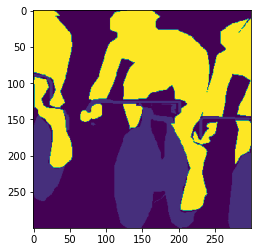

In [137]:
plt.imshow(annotation)

### Create function to load all segmentation images

In [224]:
import cv2
from PIL import Image
from matplotlib import pyplot as plt
from glob import glob
from tqdm import tqdm
import os

def load_data(VOC2012_path: str, width_height: tuple):
    jpeg_path = VOC2012_path + "VOC2012/JPEGImages/"
    segmentation_path = VOC2012_path + "VOC2012/SegmentationClass/"
    annotations_path = glob(segmentation_path + "*")
    filenames_png = []
    original_shapes = []

    print("Loading images...")
    images = []
    for el in tqdm(annotations_path):
        filename = os.path.basename(el)
        filenames_png.append(filename)
        el = jpeg_path + filename.replace(".png", ".jpg")
        image = Image.open(el)
        original_shapes.append(image.size)
        image = np.array(image)
        image = cv2.resize(image, width_height,
                           interpolation=cv2.INTER_NEAREST)
        images.append(tf.convert_to_tensor(image, dtype=tf.float32))

    print("Loading annotations...")
    annotations = []
    for el in tqdm(annotations_path):
        annotation = Image.open(el)
        annotation = np.array(annotation)
        annotation[annotation > 20] = 0
        annotation = cv2.resize(annotation, width_height,
                                interpolation=cv2.INTER_NEAREST)
        annotations.append(tf.expand_dims(tf.convert_to_tensor(annotation, dtype=tf.uint8), 2))

    print("Convert to tensor...")
    images = tf.convert_to_tensor(images, dtype=tf.float32)
    annotations = tf.convert_to_tensor(annotations, dtype=tf.uint8)
    print("Done")
    print(f"Images shape: {images.shape}, annotations shape: {annotations.shape}")
    return images, annotations, filename_list, original_shape

images, annotations, filenames_png, original_shapes = load_data("../data/VOCdevkit/", (300, 300,))

  0%|▏                                                                                | 5/2913 [00:00<01:04, 45.27it/s]

Loading images...


  2%|█▊                                                                             | 69/2913 [00:00<00:04, 634.73it/s]

Loading annotations...


100%|█████████████████████████████████████████████████████████████████████████████| 2913/2913 [00:03<00:00, 748.36it/s]


Convert to tensor...
Done
Images shape: (2913, 300, 300, 3), annotations shape: (2913, 300, 300, 1)


### Visualize random data

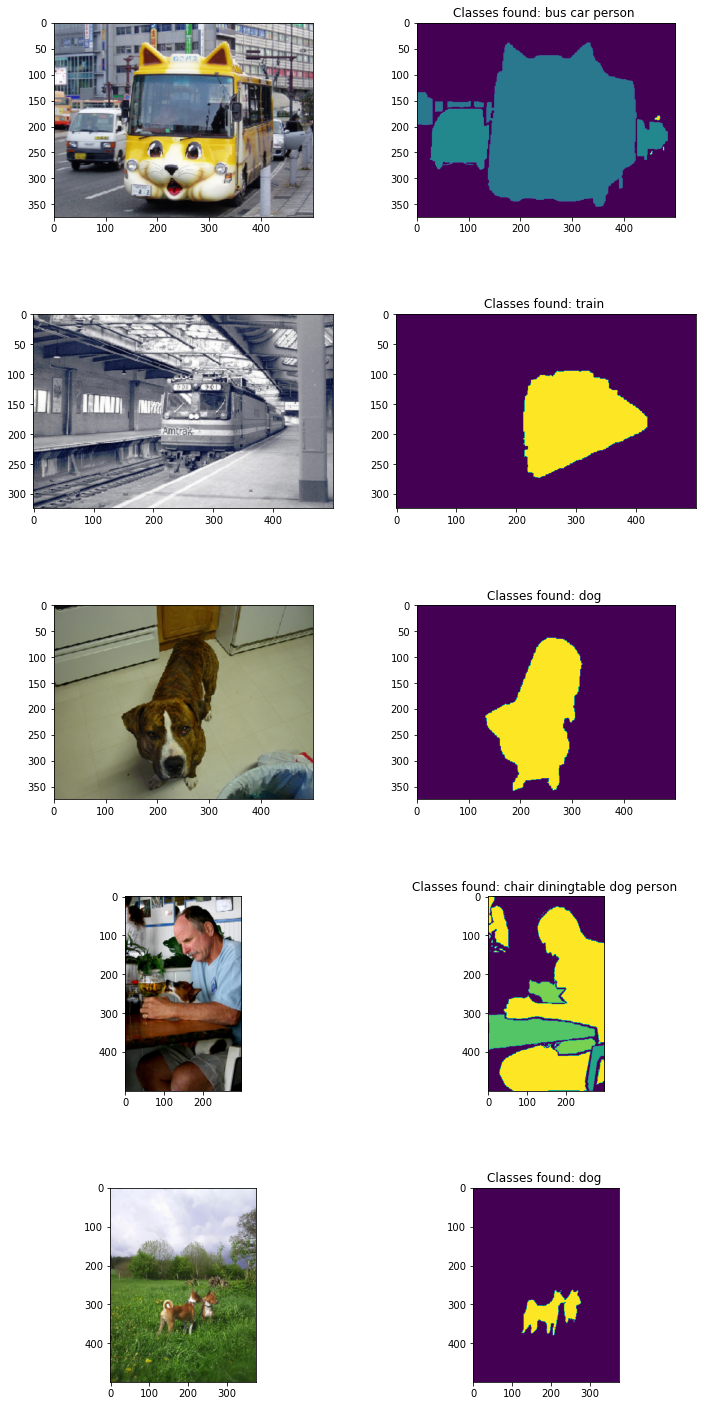

In [225]:
import random
def random_choice(inputs, n_samples, seed):
    """
    With replacement.
    Params:
      inputs (Tensor): Shape [n_states, n_features]
      n_samples (int): The number of random samples to take.
    Returns:
      sampled_inputs (Tensor): Shape [n_samples, n_features]
    """
    # (1, n_states) since multinomial requires 2D logits.
    uniform_log_prob = tf.expand_dims(tf.zeros(tf.shape(inputs)[0]), 0)
    tf.random.set_seed(seed)
    ind = tf.random.categorical(uniform_log_prob, n_samples)
    ind = tf.squeeze(ind, 0, name="random_choice_ind")  # (n_samples,)

    return tf.gather(inputs, ind, name="random_choice")

def visualize_data(images: tf.Tensor, annotations: tf.Tensor, original_shapes=None, n_samples=5, seed=42):
    images_toprint  = random_choice(images, n_samples, seed)
    annotations_toprint  = random_choice(annotations, n_samples, seed)
    if original_shapes is not None:
        original_shapes  = random_choice(original_shapes, n_samples, seed)

    fig, axs = plt.subplots(n_samples, 2,figsize=(13, 25), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()
    subplot_idx = 0
    for i in range(0, n_samples):
        image = tf.cast(images_toprint[i], dtype=tf.uint8).numpy()
        if original_shapes is not None:
            image = cv2.resize(image, tuple(original_shapes[i].numpy()), interpolation=cv2.INTER_LINEAR)
        
        annotation = annotations_toprint[i].numpy()
        if original_shapes is not None:
            annotation = cv2.resize(annotation, tuple(original_shapes[i].numpy()), interpolation=cv2.INTER_NEAREST)
        classes = np.unique(annotation)
        title = "Classes found: "
        for el in classes:
            if el != 0:
                title += labels_to_name[el] + ' '
        
        axs[subplot_idx].imshow(image)
        axs[subplot_idx+1].imshow(annotation)
        axs[subplot_idx+1].set_title(title)
        subplot_idx += 2

visualize_data(images, annotations, original_shapes, seed=42)

### Reshape segmentation maps from (height, width, 1) to (height, width, n_classes) 

In [241]:
def prepare_data(images: tf.Tensor, annotations: tf.Tensor, n_classes: int):
    # normalize images
    images = images / 255.

    gt_annotations = []
    print("Reshape segmentation maps from (height, width, 1) to (height, width, n_classes)")
    for n, annotation in enumerate(tqdm(annotations)):
        stack_list = []
        # Reshape segmentation masks
        for c in range(n_classes):
            mask = tf.equal(annotation[:,:,0], tf.constant(i, dtype=tf.uint8))
            stack_list.append(tf.cast(mask, dtype=tf.uint8))

        gt = tf.stack(stack_list, axis=2)
        gt_annotations.append(gt)
    return images, tf.convert_to_tensor(gt_annotations, dtype=tf.uint8)
images, gt_annotations = prepare_data(images, annotations, n_classes)

  0%|▎                                                                              | 13/2913 [00:00<00:23, 125.90it/s]

Reshape segmentation maps from (height, width, 1) to (height, width, n_classes)


100%|█████████████████████████████████████████████████████████████████████████████| 2913/2913 [00:21<00:00, 133.21it/s]


### Combine load, prepare and visualize to one function

  1%|▍                                                                              | 15/2913 [00:00<00:20, 139.34it/s]

Loading images...


  2%|█▍                                                                             | 52/2913 [00:00<00:06, 464.85it/s]

Loading annotations...


100%|█████████████████████████████████████████████████████████████████████████████| 2913/2913 [00:03<00:00, 741.16it/s]


Convert to tensor...
Done
Images shape: (2913, 300, 300, 3), annotations shape: (2913, 300, 300, 1)


  1%|▌                                                                              | 22/2913 [00:00<00:28, 100.58it/s]

Reshape segmentation maps from (height, width, 1) to (height, width, n_classes)


100%|█████████████████████████████████████████████████████████████████████████████| 2913/2913 [00:28<00:00, 103.53it/s]


Images shape: (2913, 300, 300, 3), annotations shape: (2913, 300, 300, 21)
Examples:


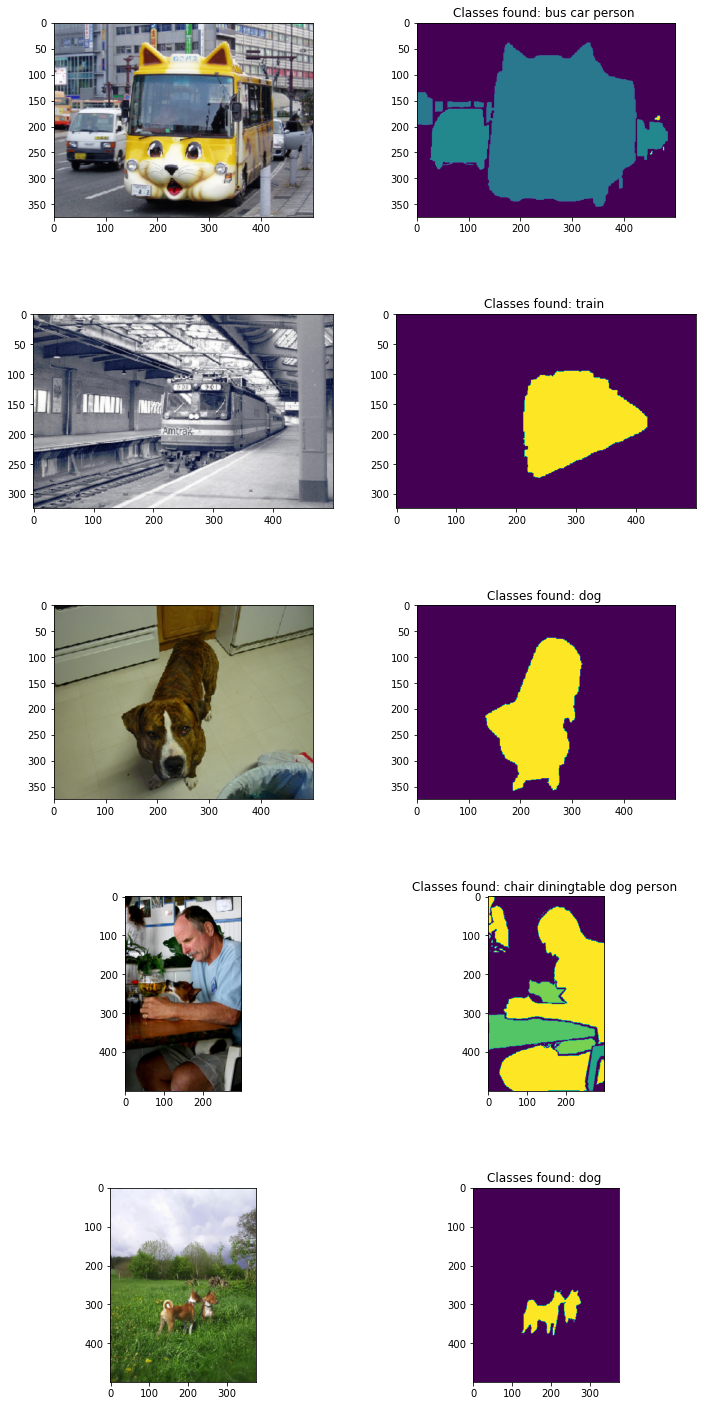

In [242]:
def load_and_prepare_data(VOC2012_path: str, width_height: tuple, n_classes=21, n_samples_to_show=0, seed=42):
    images, annotations, filenames_png, original_shapes = load_data(VOC2012_path, width_height)
    images_normalized, gt_annotations = prepare_data(images, annotations, n_classes)
    print(f"Images shape: {images_normalized.shape}, annotations shape: {gt_annotations.shape}")
    if n_samples_to_show > 0:
        print("Examples:")
        visualize_data(images, annotations, original_shapes, n_samples_to_show, seed)
    return images_normalized, gt_annotations, filenames_png, original_shapes

images, gt_annotations, filenames_png, original_shapes = load_and_prepare_data("../data/VOCdevkit/", (300, 300,), n_samples_to_show=5)